<a href="https://colab.research.google.com/github/dohyung-kim/ccri/blob/main/script/adm0/ccri_sensitivity_analysis_adm0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# CCRI Sensitivity Analysis

import os
import glob
import shutil
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore, skew, kurtosis
from scipy.stats.mstats import gmean, hmean
from sklearn.preprocessing import MinMaxScaler
debug = False

Define helper functions for normalization, aggregation, variable dropout, missing value simulation

In [25]:

# -----------------------------
# 1. Normalization Functions - this is applied whenever normalziation is done
# -----------------------------
def normalize_data(df, method='minmax'):
    if method == 'minmax':
        return 10 * (df - df.min()) / (df.max() - df.min())

    elif method == 'zscore':
        if isinstance(df, pd.Series):
            return safe_zscore(df)
        elif isinstance(df, pd.DataFrame):
            return df.apply(safe_zscore)
        else:
            raise TypeError("Input must be a Series or DataFrame for zscore normalization.")

    elif method == 'quantile':
        return df.rank(pct=True)

    else:
        raise ValueError("Unsupported normalization method")

# -----------------------------
# 2. Aggregation Functions - this is applied whenever aggregation is done
# -----------------------------
def aggregate_data(df, method='arithmetic', weights=None):
    if weights is not None:
        df = df * weights
    if method == 'arithmetic':
        return df.mean(axis=1)
    elif method == 'geometric':
        return gmean(df + 0.1, axis=1)  # add epsilon to avoid log(0)
    elif method == 'harmonic':
        return hmean(df + 0.1, axis=1)
    else:
        raise ValueError("Unsupported aggregation method")


# -----------------------------
# 3. Drop random variable - this may applied once for each p1 df and p2 df
# -----------------------------
def drop_random_variables(df, percent=0.2, protected_columns=['ISO3', 'name', 'iso3']):
    """
    Randomly drops a percentage of columns (excluding protected ones).
    """
    df_copy = df.copy()
    drop_candidates = [col for col in df_copy.columns if col not in protected_columns]
    n_drop = int(len(drop_candidates) * percent)
    drop_cols = random.sample(drop_candidates, n_drop)
    return df_copy.drop(columns=drop_cols), drop_cols



def impute_missing(df, method='mean'):
    df_copy = df.copy()

    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    non_numeric_cols = df_copy.columns.difference(numeric_cols)

    if method == 'mean':
        df_copy[numeric_cols] = df_copy[numeric_cols].fillna(df_copy[numeric_cols].mean())
    elif method == 'median':
        df_copy[numeric_cols] = df_copy[numeric_cols].fillna(df_copy[numeric_cols].median())
    elif method == 'zero':
        df_copy[numeric_cols] = df_copy[numeric_cols].fillna(0)
    elif method == 'max':
        df_copy[numeric_cols] = df_copy[numeric_cols].fillna(df_copy[numeric_cols].max())
    elif method == 'min':
        df_copy[numeric_cols] = df_copy[numeric_cols].fillna(df_copy[numeric_cols].min())
    elif method == 'ffill':
        df_copy[numeric_cols] = df_copy[numeric_cols].ffill()
    elif method == 'bfill':
        df_copy[numeric_cols] = df_copy[numeric_cols].bfill()
    elif method == 'none':
        return df_copy
    else:
        raise ValueError("Unsupported imputation method")

    return df_copy


#utility function that randomly selects one value from a requested criteria category
def get_random_choice(criteria):
    options = {
        'norm_methods': ['minmax', 'zscore'],
        'agg_methods': ['arithmetic', 'geometric'],
        'drop_percents': [0, 0.1, 0.2],
        'impute_methods': ['mean', 'median','none']
    }

    if criteria not in options:
        raise ValueError(f"Invalid criteria '{criteria}'. Must be one of: {list(options.keys())}")

    return random.choice(options[criteria])

def safe_zscore(series):
    if series.std(ddof=0) == 0 or series.isna().all():
        # Return neutral values if constant or all NaNs
        return pd.Series([1.0] * len(series), index=series.index)

    z = zscore(series, nan_policy='omit')
    shift = abs(np.nanmin(z)) + 1e-6
    return pd.Series(z + shift, index=series.index)

def sample_run_parameters(trial):
    return {
        'trial': trial,
        'p1_norm_method': get_random_choice('norm_methods'),
        'p1_agg_method': get_random_choice('agg_methods'),
        'p1_sub_norm_method': get_random_choice('norm_methods'),
        'p1_sub_agg_method': get_random_choice('agg_methods'),
        'p1_drop_percent': get_random_choice('drop_percents'),
        'p2_drop_percent': get_random_choice('drop_percents'),
        'p2_norm_method': get_random_choice('norm_methods'),
        'p2_agg_method': get_random_choice('agg_methods'),
        'p2_sub_norm_method': get_random_choice('norm_methods'),
        'p2_sub_agg_method': get_random_choice('agg_methods'),
        'p2_impute_method': get_random_choice('impute_methods'),
        'p1_p2_norm_method': get_random_choice('norm_methods'),
        'p1_p2_agg_method': get_random_choice('agg_methods'),
        'final_agg_method': get_random_choice('agg_methods')
    }

Pillar 1

In [26]:
def p1_exposure_processing(exposure_path, total_population_file, p1_min_max_values, params):

  # Load total child population data
  total_pop_df = pd.read_csv(total_population_file, usecols=['ISO3', 'name', 'child_population'])

  # Ensure unique ISO3-name pairs before merging
  total_pop_df = total_pop_df.groupby(['ISO3', 'name'], as_index=False).agg({'child_population': 'mean'})

  # Get all CSV files for exposure
  exposure_files = glob.glob(os.path.join(exposure_path, "*.csv"))

  # Initialize empty list for processed data
  exposure_data_list = []

  ### **Process Each File in One Loop**
  for idx, file in  enumerate(exposure_files):
      if file == total_population_file:
          continue  # Skip total population file

      df = pd.read_csv(file)  # Read full file to check available columns
      filename_only = os.path.basename(file)
      hazard_name = '_'.join(filename_only.split('_')[:2])  # Extract hazard name

      # Ensure required columns exist
      required_cols = {'ISO3', 'name', 'child_population_exposed'}
      if not required_cols.issubset(df.columns):
          print(f"Skipping {file}: Missing columns {required_cols - set(df.columns)}")
          continue  # Skip if required columns are missing

      df.dropna(subset=['child_population_exposed'], inplace=True)

      ### **Step 1: Absolute Exposure Processing**
      # Log transform with clipping for values >100, otherwise assign 0.1
      df['absolute_exposure'] = np.where(df['child_population_exposed'] > 100,
                                        np.log10(df['child_population_exposed'].clip(lower=1)),  # Clip to avoid log10(0)
                                        0.1)
      #open min_max data file and use them to normalize the values
      df_min_max = pd.read_csv(p1_min_max_values)
      min_trimmed = df_min_max.loc[(df_min_max['filename'] == hazard_name) & (df_min_max['type'] == 'abs'),'min'].values[0]
      max_trimmed = df_min_max.loc[(df_min_max['filename'] == hazard_name) & (df_min_max['type'] == 'abs'),'max'].values[0]

      # clip to min max
      df['absolute_exposure'] = np.clip(df['absolute_exposure'], min_trimmed, max_trimmed)
      # Normalize using min_trimmed and max_trimmed
      df['absolute_value_normalized'] = normalize_data(df['absolute_exposure'], method=params['p1_norm_method']) ############# randomly chose and apply a normalization method

      if debug == True:
        print(df['absolute_value_normalized'])

      ### **Step 2: Relative Exposure Processing**
      # Merge with total population data
      df = df.merge(total_pop_df, on=['ISO3', 'name'], how='left')

      # Compute relative exposure (%)
      df['relative_exposure'] = np.where(
          (df['child_population'] > 0) & (~df['child_population'].isna()),
          (df['child_population_exposed'] / df['child_population']) * 100,
          0
      )

      #get min max values for relative exposures
      min_trimmed = df_min_max.loc[(df_min_max['filename'] == hazard_name) & (df_min_max['type'] == 'rel'),'min'].values[0]
      max_trimmed = df_min_max.loc[(df_min_max['filename'] == hazard_name) & (df_min_max['type'] == 'rel'),'max'].values[0]

      # Normalize relative exposure
      df['relative_exposure'] = np.clip(df['relative_exposure'], min_trimmed, max_trimmed)
      df['relative_value_normalized'] = normalize_data(df['relative_exposure'], method=params['p1_norm_method']) ############# randomly chose and apply a normalization method

      if debug == True:
        print(df['relative_value_normalized'])

      # Rename columns for final merging
      df.rename(columns={
          'absolute_value_normalized': hazard_name + '_absolute',
          'relative_value_normalized': hazard_name + '_relative'
      }, inplace=True)

      # Append processed data to list
      exposure_data_list.append(df[['ISO3', 'name',
                                    hazard_name + '_absolute',
                                    hazard_name + '_relative', ]])

  ### **Final Merge Step**
  # Concatenate all processed DataFrames
  merged_exposure_df = pd.concat(exposure_data_list, axis=1).drop_duplicates(subset=['ISO3', 'name'])

  # Ensure no duplicate columns before merging
  merged_exposure_df = merged_exposure_df.loc[:, ~merged_exposure_df.columns.duplicated()]

  return merged_exposure_df


Pillar 2

In [27]:

def p2_vulnerability_processing(source_folder, destination_folder, p2_min_max_values, params):
  # Get all copied CSV files
  csv_files = glob.glob(os.path.join(source_folder, "*.csv"))

  # List of variables to reverse normalize
  reverse_columns = [
      'P2_LSCED',
      'P2_Birth_Attendant_Y15T19',
      'P2_ED_CR_L2',
      'P2_Immunization_DTP1',
      'P2_Immunization_DTP3',
      'P2_WASH_Drinking_Water',
      'P2_WASH_Sanitation',
      'P2_basic_hygiene',
      'P2_electricity_access',
      'P2_Social_Protection'
  ]

  # Initialize an empty DataFrame for merged results
  merged_df = pd.DataFrame()

  for file in csv_files:
      df = pd.read_csv(file)
      # Extract filename for column naming
      filename = os.path.basename(file).replace(".csv", "")

      if 'iso3' not in df.columns or 'value' not in df.columns:
          continue  # Skip files missing required columns
      # Normalize 'value' column
      df = df[['iso3', 'value']].dropna()

      df_min_max = pd.read_csv(os.path.join(destination_folder,'p2_min_max.csv'))

      df_min_max['filename'] = df_min_max['filename'].astype(str).str.strip()
      filename = str(filename).strip()

      min_trimmed = df_min_max.loc[(df_min_max['filename'] == filename),'min'].values[0]
      max_trimmed = df_min_max.loc[(df_min_max['filename'] == filename),'max'].values[0]

      # clip to min max
      df['value'] = np.clip(df['value'], min_trimmed, max_trimmed)
      current_min = df['value'].min()
      current_max = df['value'].max()

      # Normalize using final min/max
      df['value_normalized'] = normalize_data(df['value'], method=params['p2_sub_norm_method']) ############# randomly chose and apply a normalization method

      # Reverse normalization for specific columns
      if filename in reverse_columns:
          if params['p2_sub_norm_method'] == 'minmax':
              df['value_normalized'] = 10 - df['value_normalized']
          elif params['p2_sub_norm_method'] == 'zscore':
              df['value_normalized'] = -df['value_normalized']
          elif params['p2_sub_norm_method'] == 'quantile':
              df['value_normalized'] = 1 - df['value_normalized']

      # Rename column
      df.rename(columns={'value_normalized': filename + '_value_normalized'}, inplace=True)

      # Merge with the main DataFrame (use suffixes to avoid column name conflicts)
      if merged_df.empty:
          merged_df = df[['iso3', filename + '_value_normalized']]
      else:
          merged_df = merged_df.merge(df[['iso3', filename + '_value_normalized']],
                                      on='iso3', how='left', suffixes=('', f'_{filename}'))

  if debug == True:
    print(merged_df)

  #randomized imputation
  merged_df = impute_missing(merged_df, method=params['p2_impute_method']) ############# randomly chose and apply a imputation method


  # Filter columns that end with '_value_normalized'
  health_prefixes = ['P2_Immunization_DTP1', 'P2_Immunization_DTP3', 'P2_Birth_Attendant_Y15T19', 'P2_electricity_access']
  health_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in health_prefixes)]
  nutrition_prefixes = ['P2_Nutrition_Stunting_Modeled', 'P2_food_poverty']
  nutrition_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in nutrition_prefixes)]
  wash_prefixes = ['P2_WASH_Drinking_Water', 'P2_WASH_Sanitation', 'P2_basic_hygiene']
  wash_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in wash_prefixes)]
  education_prefixes = ['P2_LSCED', 'P2_ED_CR_L2', 'P2_Learning_Poverty']
  education_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in education_prefixes)]
  protection_prefixes = ['P2_PT_Labor', 'P2_Child_Marriage']
  protection_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in protection_prefixes)]
  poverty_prefixes = ['P2_Child_poverty', 'P2_Social_Protection']
  poverty_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in poverty_prefixes)]
  survival_prefixes = ['P2_Child_Mortality']
  survival_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in poverty_prefixes)]

  with warnings.catch_warnings(): ############# randomly chose and apply a aggregation method
    warnings.simplefilter("ignore", category=RuntimeWarning)
    health_avg = aggregate_data(merged_df[health_columns], method=params['p2_sub_agg_method'])
    nutrition_avg = aggregate_data(merged_df[nutrition_columns], method=params['p2_sub_agg_method'])
    wash_avg = aggregate_data(merged_df[wash_columns], method=params['p2_sub_agg_method'])
    education_avg = aggregate_data(merged_df[education_columns], method=params['p2_sub_agg_method'])
    protection_avg = aggregate_data(merged_df[protection_columns], method=params['p2_sub_agg_method'])
    poverty_avg = aggregate_data(merged_df[poverty_columns], method=params['p2_sub_agg_method'])
    survival_avg = aggregate_data(merged_df[survival_columns], method=params['p2_sub_agg_method'])

  # Combine all into a DataFrame
  domains_df = pd.DataFrame({
      'health': health_avg,
      'nutrition': nutrition_avg,
      'wash': wash_avg,
      'education': education_avg,
      'protection': protection_avg,
      'poverty': poverty_avg,
      'survival': survival_avg
  })

  #normalize domain dfs
  domains_scaled = normalize_data(domains_df, method=params['p2_norm_method'])   ############# randomly chose and apply a normalization method

  # Compute the average across all '_value_normalized' columns (ignoring NaNs)
  merged_df["P2_avg"] = aggregate_data(domains_scaled, method=params['p2_agg_method']) ############# randomly chose and apply a agg method

  current_min = merged_df['P2_avg'].min()
  current_max = merged_df['P2_avg'].max()

  # Normalize using final min/max - this time just minmax scaler used to bring to the reange of 0 to 10
  merged_df['P2_avg'] = 10 * (merged_df['P2_avg'] - current_min) / (current_max - current_min)

  return merged_df

P1 P2 aggregation

In [28]:

def p1_p2_aggregation(df_P1, df_P2, params):
  # Step 1: Calculate Geometric Mean between '_absolute' and '_relative' columns for df_P1
  # List of columns ending with '_absolute' and '_relative'
  df_P1, drop_cols = drop_random_variables(df_P1, percent=params['p1_drop_percent']) ############# randomly chose and apply a variable dropout method
  #df_P2, drop_cols = drop_random_variables(df_P2, percent=params['p2_drop_percent']) ############# randomly chose and apply a variable dropout method

  absolute_columns = [col for col in df_P1.columns if '_absolute' in col]
  relative_columns = [col for col in df_P1.columns if '_relative' in col]

  # Calculate geometric mean for each pair of '_absolute' and '_relative' columns
  for abs_col, rel_col in zip(absolute_columns, relative_columns):
      # Apply geometric mean for each pair, ignoring NaN values
      df_P1[abs_col + '_mean'] = aggregate_data(df_P1[[abs_col, rel_col]], method=params['p1_sub_agg_method']) ############# randomly chose and apply a aggregation method

      min_value = df_P1[abs_col + '_mean'].min()
      max_value = df_P1[abs_col + '_mean'].max()
      # Scale the df_P1[abs_col + '_mean'] column to range from 0 to 10
      df_P1[abs_col + '_mean'] = normalize_data(df_P1[abs_col + '_mean'], method=params['p1_sub_norm_method'])   ############# randomly chose and apply a normalization method

  # Step 2: Calculate Geometric Mean across all '_mean' columns in df_P1
  # Select columns that are the geometric means (those ending with '_mean')
  geometric_mean_columns = [col for col in df_P1.columns if '_mean' in col]

  # Calculate the geometric mean for each row across all geometric mean columns
  df_P1['P1_avg'] = aggregate_data(df_P1[geometric_mean_columns],  method=params['p1_agg_method']) ############# randomly chose and apply a aggregation method

  # # Step 2: Apply Min-Max scaling to 'P1_geometric_avg' based on the plot
  # df_P1['P1_geometric_avg'] = np.clip(df_P1['P1_geometric_avg'], 0, 0.005)

  # Step 6: Apply Min-Max Scaling to 'P1_p2_geometric_avg' to the range 0-10
  min_value = df_P1['P1_avg'].min()
  max_value = df_P1['P1_avg'].max()

  # Scale the 'P1_geometric_avg' column to range from 0 to 10
  df_P1['P1_avg'] = 10 * (df_P1['P1_avg'] - min_value) / (max_value - min_value)

  # Step 3: Group by 'ISO3' and calculate the average of 'P1_geometric_avg' for each 'ISO3'
  df_P1_grouped = df_P1.groupby('ISO3', as_index=False)['P1_avg'].mean()

  # Step 4: Merge df_P1_grouped with df_P2 on 'ISO3'
  merged_df = df_P1_grouped.merge(df_P2[['iso3', 'P2_avg']], left_on='ISO3', right_on='iso3', how='left')

  # Step 5: Calculate the Mean between 'P1_avg' and 'P2_avg'
  merged_df['P1_P2_avg'] = aggregate_data(merged_df[['P1_avg', 'P2_avg']], method=params['final_agg_method']) ############# randomly chose and apply a aggregation method

  # #final clip and normalization!!!
  # merged_df['P1_P2_geometric_avg'] = np.clip(merged_df['P1_P2_geometric_avg'], 0, 0.0025)

  # Step 6: Apply Min-Max Scaling to 'P1_p2_geometric_avg' to the range 0-10
  min_value = merged_df['P1_P2_avg'].min()
  max_value = merged_df['P1_P2_avg'].max()
  # Scale the 'P1_p2_geometric_avg' column to range from 0 to 10
  merged_df['P1_P2_avg'] = 10 * (merged_df['P1_P2_avg'] - min_value) / (max_value - min_value)

  return merged_df

In [29]:
# Define file paths
exposure_path = "/content/drive/MyDrive/p1_exposure"
total_population_file = "/content/drive/MyDrive/CCRI_results_misc/child_pop_sum_adm0.csv"
p1_min_max_values = '/content/drive/MyDrive/CCRI_results_misc/p1_min_max.csv'
p2_min_max_values = '/content/drive/MyDrive/CCRI_results_misc/p2_min_max.csv'
p2_source_folder = "/content/drive/MyDrive/p2_vulnerability/"
destination_folder = "/content/drive/MyDrive/CCRI_results_misc/"
data_dir = '/content/drive/MyDrive/CCRI_results_misc/'

child_pop_sum = pd.read_csv(total_population_file)
child_pop_sum_grouped = child_pop_sum.groupby('ISO3', as_index=False)['child_population'].sum()
num_trials = 100
debug = False
run_log = []
child_pop_trials = child_pop_sum_grouped[['ISO3','child_population']]
TH = 75

for trial in range(num_trials):
  params = sample_run_parameters(trial)
  run_log.append(params)

  p1_df = p1_exposure_processing(exposure_path, total_population_file, p1_min_max_values,params)
  p2_df = p2_vulnerability_processing(p2_source_folder, destination_folder,p2_min_max_values,params)
  p1_p2_df = p1_p2_aggregation(p1_df, p2_df,params)

  # ccri_score
  ccri_score = p1_p2_df[['ISO3','P1_P2_avg']].rename(
      columns={'P1_P2_avg': f'trial_{trial}'}
  )

  # Merge the ccri_score DataFrame with the grouped child population data on 'ISO3'
  child_pop_trials = child_pop_trials.merge(ccri_score, on='ISO3', how='left')




print(f"finished CCRI senstivity analysis with {num_trials} trials")


finished CCRI senstivity analysis with 100 trials


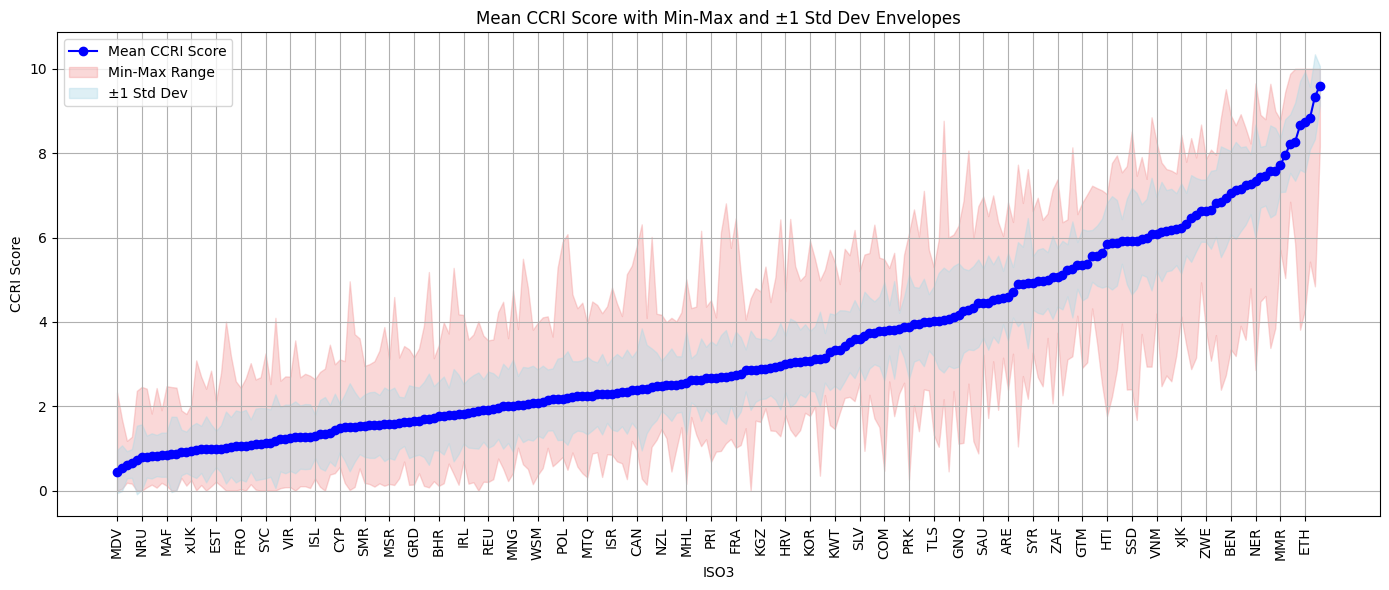

In [30]:

# Step 1: Drop trial columns where all values are NaN or all 0
trial_cols = [col for col in child_pop_trials.columns if col.startswith('trial_')]
non_empty_trials = child_pop_trials[trial_cols].dropna(axis=1, how='all')
non_zero_trials = non_empty_trials.loc[:, (non_empty_trials != 0).any(axis=0)]

# Step 2: Reattach ISO3
child_pop_cleaned = pd.concat([child_pop_trials[['ISO3']], non_zero_trials], axis=1)

# Step 3: Drop rows (ISOs) where all trial values are zero or NaN
data_only = child_pop_cleaned.drop(columns='ISO3')
non_zero_rows = data_only.loc[(data_only != 0).any(axis=1) & (~data_only.isna().all(axis=1))]
child_pop_cleaned = pd.concat([child_pop_cleaned[['ISO3']], non_zero_rows], axis=1)

# Step 4: Compute stats
data_only = child_pop_cleaned.drop(columns='ISO3')
mean_vals = data_only.mean(axis=1).to_numpy(dtype=float)
min_vals = data_only.min(axis=1).to_numpy(dtype=float)
max_vals = data_only.max(axis=1).to_numpy(dtype=float)
std_vals = data_only.std(axis=1).to_numpy(dtype=float)

# Step 5: Filter out rows where mean is 0
non_zero_mean_mask = mean_vals != 0
mean_vals = mean_vals[non_zero_mean_mask]
min_vals = min_vals[non_zero_mean_mask]
max_vals = max_vals[non_zero_mean_mask]
std_vals = std_vals[non_zero_mean_mask]
iso3s = child_pop_cleaned['ISO3'].to_numpy()[non_zero_mean_mask]

# Step 6: Sort by mean values
sort_order = mean_vals.argsort()
mean_vals = mean_vals[sort_order]
min_vals = min_vals[sort_order]
max_vals = max_vals[sort_order]
std_vals = std_vals[sort_order]
iso3s = iso3s[sort_order]

# Step 7: Plot with both Min-Max and ±1 Std Dev envelopes
x = range(len(mean_vals))
upper_sd = mean_vals + std_vals
lower_sd = mean_vals - std_vals

plt.figure(figsize=(14, 6))
plt.plot(x, mean_vals, label='Mean CCRI Score', color='blue', marker='o')
plt.fill_between(x, min_vals, max_vals, color='lightcoral', alpha=0.3, label='Min-Max Range')
plt.fill_between(x, lower_sd, upper_sd, color='lightblue', alpha=0.4, label='±1 Std Dev')

# Customize x-axis
plt.xticks(ticks=x[::5], labels=iso3s[::5], rotation=90)

# Labels and title
plt.xlabel('ISO3')
plt.ylabel('CCRI Score')
plt.title('Mean CCRI Score with Min-Max and ±1 Std Dev Envelopes')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [31]:
# Extract trial columns and drop ISO3 for numeric ops
trial_cols = [col for col in child_pop_trials.columns if col.startswith('trial_')]
data_only = child_pop_trials[trial_cols]

# Compute stats
summary_df = pd.DataFrame({
    'ISO3': child_pop_trials['ISO3'],
    'mean_score': data_only.mean(axis=1),
    'std_dev': data_only.std(axis=1),
    'min_score': data_only.min(axis=1),
    'max_score': data_only.max(axis=1),
    'range': data_only.max(axis=1) - data_only.min(axis=1),
    'coefficient_of_variation': data_only.std(axis=1) / data_only.mean(axis=1)
})

# Countries with high variability
high_variability = summary_df[summary_df['std_dev'] > 1.0]  # example threshold

# Or flag top N most unstable
top_unstable = summary_df.sort_values(by='std_dev', ascending=False).head(10)

top_unstable

,ISO3,mean_score,std_dev,min_score,max_score,range,coefficient_of_variation
249,xAB,4.918819,1.543999,2.178453,7.621467,5.443015,0.313896
221,TKM,2.399978,1.447196,0.285350,6.313089,6.027739,0.603004
161,NER,7.337475,1.341414,2.859017,9.654692,6.795676,0.182817
67,ERI,6.081517,1.334771,2.939706,8.850280,5.910573,0.219480
38,CAF,6.848078,1.313692,2.392257,8.834108,6.441850,0.191834
205,SSD,5.913905,1.263385,2.404074,8.515385,6.111311,0.213630
234,USA,4.044166,1.243937,2.168447,8.768428,6.599981,0.307588
181,PRK,3.883956,1.233780,0.260361,6.106134,5.845773,0.317661
88,GNQ,4.164977,1.226312,1.112035,6.279197,5.167162,0.294434
143,MHL,2.552004,1.216619,0.160285,5.010974,4.850690,0.476731


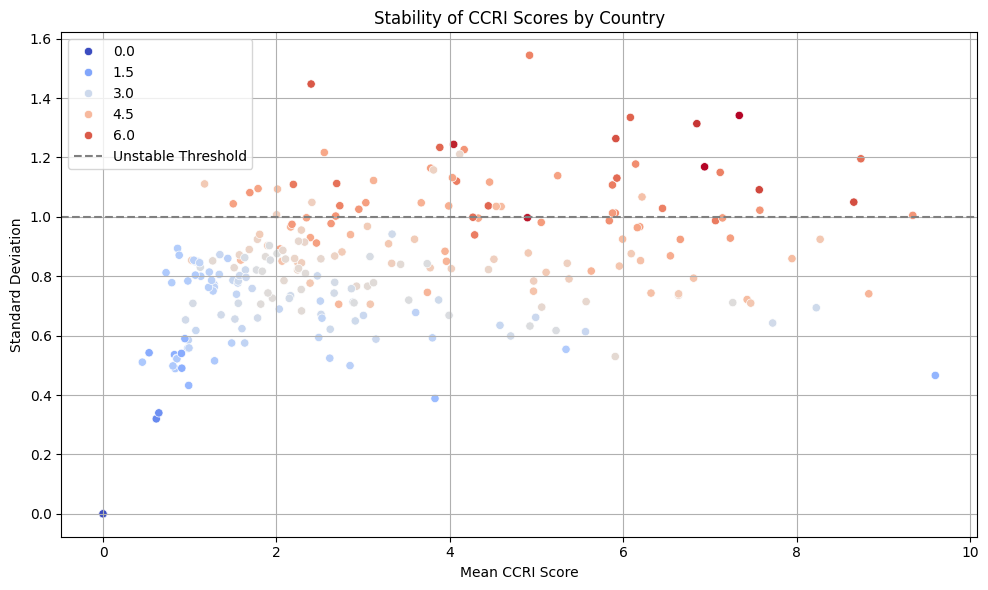

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary_df, x='mean_score', y='std_dev', hue='range', palette='coolwarm')
plt.axhline(1.0, color='gray', linestyle='--', label='Unstable Threshold')
plt.xlabel("Mean CCRI Score")
plt.ylabel("Standard Deviation")
plt.title("Stability of CCRI Scores by Country")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
# Get rank per trial (lower = better)
rank_df = child_pop_trials[trial_cols].rank(ascending=False, axis=0)

# Compute rank range, std, or IQR
rank_stats = pd.DataFrame({
    'ISO3': child_pop_trials['ISO3'],
    'rank_range': rank_df.max(axis=1) - rank_df.min(axis=1),
    'rank_std_dev': rank_df.std(axis=1)
}).set_index('ISO3')

top_rank_fluctuation = rank_stats.sort_values(by='rank_range', ascending=False).head(10)
top_rank_fluctuation

,rank_range,rank_std_dev
ISO3,,
BLZ,224.0,40.663315
TUV,211.0,42.854557
ARM,210.0,47.442466
SYC,205.0,33.909036
KIR,205.0,38.668518
WSM,204.0,34.040841
NLD,204.0,39.991503
TON,203.0,39.310386
VGB,198.0,41.341622


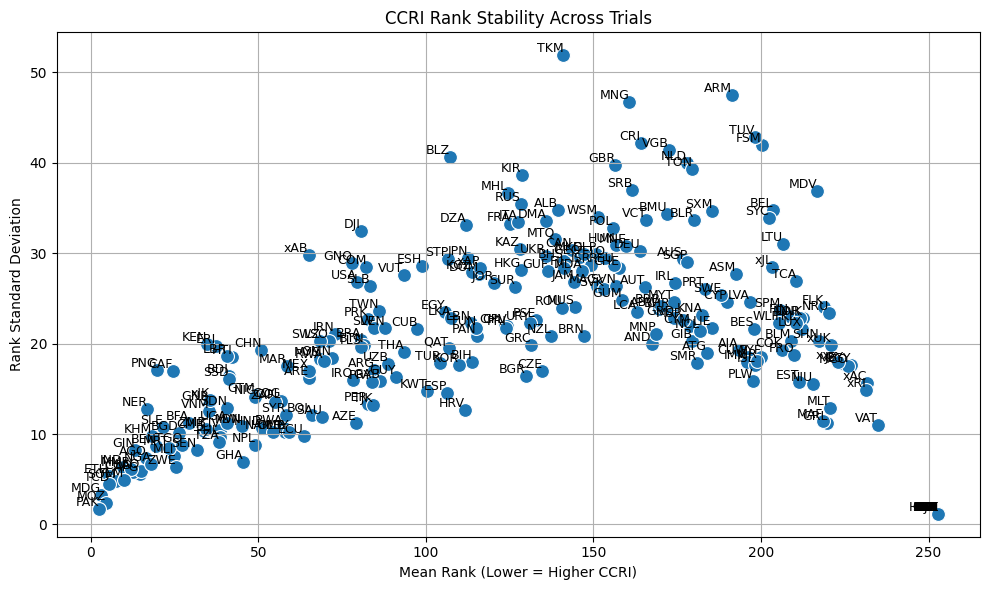

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate ranks (lower rank = higher CCRI score)
trial_cols = [col for col in child_pop_trials.columns if col.startswith('trial_')]
rank_df = child_pop_trials.set_index('ISO3')[trial_cols].rank(ascending=False, axis=0)

# Filter out countries with all NaN or all zero ranks
valid_ranks = rank_df.loc[(~rank_df.isna().all(axis=1)) & (rank_df != 0).any(axis=1)]

# Compute statistics
rank_std = valid_ranks.std(axis=1)
rank_mean = valid_ranks.mean(axis=1)

# Create scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rank_mean, y=rank_std, s=100)

# Annotate ISO3 codes
for iso, x, y in zip(valid_ranks.index, rank_mean, rank_std):
    plt.text(x, y, iso, fontsize=9, ha='right', va='bottom')

plt.title("CCRI Rank Stability Across Trials")
plt.xlabel("Mean Rank (Lower = Higher CCRI)")
plt.ylabel("Rank Standard Deviation")
plt.grid(True)
plt.tight_layout()
plt.show()


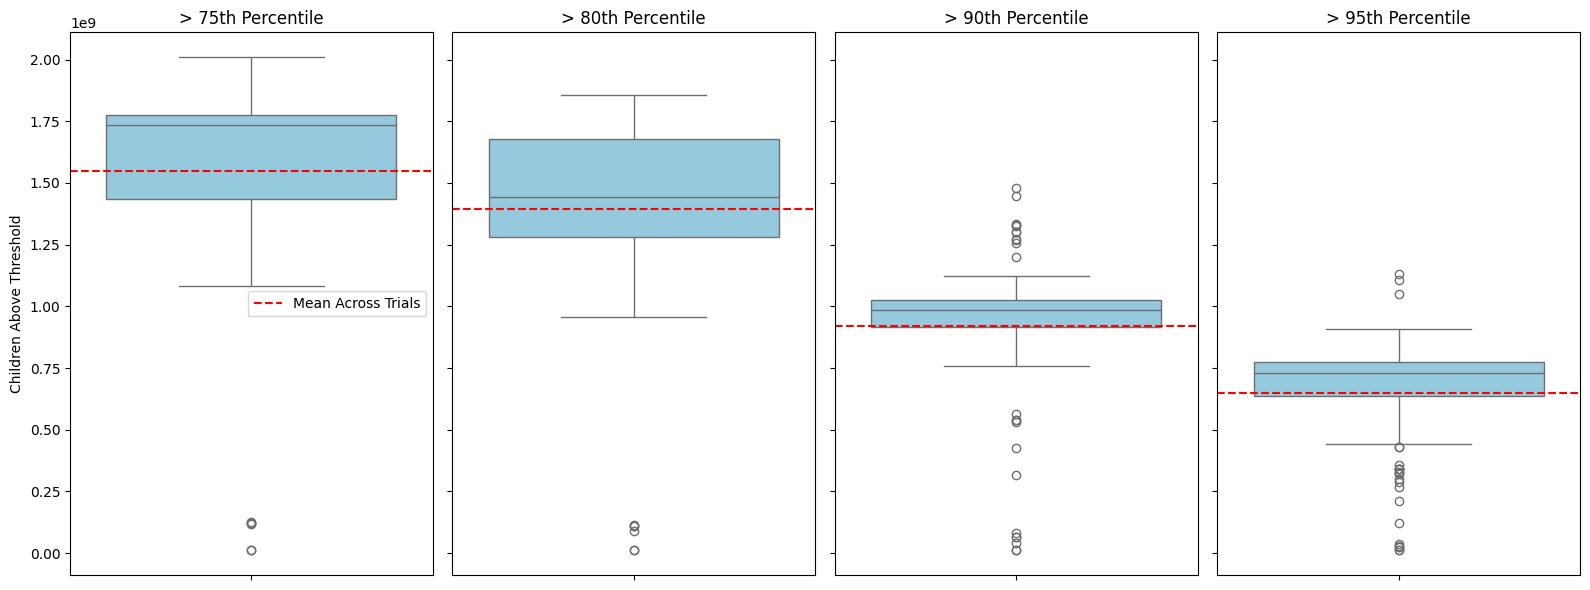

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define threshold
thresholds = [75, 80, 90, 95]
box_data = {}
# Load and prepare population data
total_population_file = "/content/drive/MyDrive/CCRI_results_misc/child_pop_sum_adm0.csv"
child_pop_sum = pd.read_csv(total_population_file)
child_pop_sum_grouped = child_pop_sum.groupby('ISO3', as_index=False)['child_population'].sum()
child_population = child_pop_sum_grouped.set_index('ISO3')['child_population']

# Filter CCRI scores
trial_cols = [col for col in child_pop_trials.columns if col.startswith('trial_')]
ccri_scores_only = child_pop_trials.set_index('ISO3')[trial_cols]
valid_iso3s = ccri_scores_only.loc[
    (~ccri_scores_only.isna().all(axis=1)) & (ccri_scores_only != 0).any(axis=1)
].index
ccri_scores_only = ccri_scores_only.loc[valid_iso3s]
child_population = child_population.loc[valid_iso3s]

# Calculate exposed children for each threshold
for TH in thresholds:
    children_above = []
    for col in ccri_scores_only.columns:
        col_data = ccri_scores_only[col]
        if col_data.isna().all():
            continue
        threshold = np.nanpercentile(col_data, TH)
        above_th = col_data > threshold
        total_children = child_population[above_th].sum()
        children_above.append(total_children)
    box_data[TH] = children_above

# Create side-by-side boxplots
fig, axes = plt.subplots(1, len(thresholds), figsize=(16, 6), sharey=True)
for idx, TH in enumerate(thresholds):
    sns.boxplot(y=box_data[TH], ax=axes[idx], color='skyblue')
    axes[idx].axhline(np.mean(box_data[TH]), color='red', linestyle='--', label='Mean Across Trials')
    axes[idx].set_title(f'> {TH}th Percentile')
    axes[idx].set_xlabel('')

axes[0].set_ylabel('Children Above Threshold')
for ax in axes[1:]:
    ax.set_ylabel('')
axes[0].legend()

plt.tight_layout()
plt.show()


In [36]:
# Step 1: Extract trial columns
trial_cols = [col for col in child_pop_trials.columns if col.startswith('trial_')]
ccri_scores = child_pop_trials[trial_cols]

# Step 2: Compute the mean score across all trials (per country), then the overall mean
country_means = ccri_scores.mean(axis=1)
trial_means = ccri_scores.mean(axis=0)

overall_mean = country_means.mean()

# Step 3: Find the trial whose mean score is closest to the overall mean
closest_trial = trial_means.sub(overall_mean).abs().idxmin()

# Step 4: Extract trial number from the column name
closest_trial_number = int(closest_trial.split('_')[1])

# Step 5: Retrieve corresponding run_log entry
selected_run_log = run_log[closest_trial_number] if closest_trial_number < len(run_log) else None

# Output result
closest_trial_number, selected_run_log


(18,
 {'trial': 18,
  'p1_norm_method': 'minmax',
  'p1_agg_method': 'geometric',
  'p1_sub_norm_method': 'zscore',
  'p1_sub_agg_method': 'geometric',
  'p1_drop_percent': 0.2,
  'p2_drop_percent': 0.2,
  'p2_norm_method': 'minmax',
  'p2_agg_method': 'arithmetic',
  'p2_sub_norm_method': 'minmax',
  'p2_sub_agg_method': 'geometric',
  'p2_impute_method': 'mean',
  'p1_p2_norm_method': 'zscore',
  'p1_p2_agg_method': 'arithmetic',
  'final_agg_method': 'arithmetic'})